In [2]:
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

In [3]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']

In [1]:
INPUT_ROOT2 = '/media/hiroki/HDD1TB/research/dcase2021_task2/output/MahalanobisAD_orig_add_data_32k/extraction_features'

# load library

In [4]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# ML lib
import scipy
from scipy.stats import zscore
from umap import UMAP
from sklearn.mixture import GaussianMixture
from sklearn.covariance import LedoitWolf
from scipy.spatial.distance import mahalanobis


import librosa
import IPython
import librosa.display

# load config and set logger

In [5]:
log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/eval{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '01_eval.py')

# Setting

In [6]:
# Setting seed
modeler.set_seed(42)

In [7]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_dir = INPUT_ROOT + "/dev_data"
add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = os.listdir(dev_dir)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/ID_Conditional_VAE/augmentation/config.yaml'

# load data

In [8]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [9]:
data_types = ['train', 'valid_source', 'valid_target']

In [18]:
def load_ext_data(machine_type):
    input_path = f'{OUT_FEATURE_DIR}/{machine_type}_features.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

In [13]:
def load_ext_data_for2(machine_type):
    input_path = f'{INPUT_ROOT2}/{machine_type}_features.pkl'
    ext_data = pd.read_pickle(input_path)
    
    return ext_data

In [11]:
# for train datasets
def get_target_names(wav_names):
    target_names = []
    for wav_name in wav_names:
        if 'target' in wav_name:
            target_names.append(wav_name)
    
    return target_names

# evaluation

## calc MVG (multivariate Gaussian)

In [21]:
com.tic()

MVG = {}
for machine_type in machine_types:
    MVG[machine_type] = {}
    ext_data = load_ext_data(machine_type)
    ext_data2 = load_ext_data_for2(machine_type)
    ext_data['train']['features'] = np.concatenate([ext_data['train']['features'], ext_data2['train']['features']])
    ext_data['train']['labels'] = 
    ext_data['train']['wav_names'] = 
    
    mean = ext_data['train']['features'].mean(axis=0)
    cov_estimator = LedoitWolf()
    cov_estimator.fit(ext_data['train']['features'])
    cov = cov_estimator.covariance_
    MVG[machine_type]['mean'] = mean
    MVG[machine_type]['cov'] = cov

com.toc()

elapsed time: 46.723669767 [sec]


## estimate

In [22]:
def calc_mahalanobis(mean, cov, samples):
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    dists = [mahalanobis(sample, mean, cov_inv) for sample in samples]
    # np.array
    dists = np.array(dists)
    return dists

In [23]:
from IPython.display import display

In [24]:
def get_score_perID(describe_df, max_fpr=0.1):
    # ユニークsectionを取得、昇順ソート
    sections = np.sort(describe_df['section_types'].unique())

    for section in sections:
        per_section_df = describe_df[describe_df['section_types'] == section]
        per_section_AUC = roc_auc_score(per_section_df['labels'], per_section_df['preds'])
        per_section_pAUC = roc_auc_score(per_section_df['labels'], per_section_df['preds'], max_fpr=max_fpr)
        # column = [AUC,pAUC], row = index
        score_df = pd.DataFrame(np.stack([per_section_AUC, per_section_pAUC]), index=['AUC', 'pAUC']).T
        # indexをsectionナンバーにrename
        # column = [AUC,pAUC], row = [section]
        score_df.index = [section]
        if section == 0:
            scores_df = score_df.copy()
        else:
            # 結合
            scores_df = scores_df.append(score_df)
    return scores_df

## Calc Score

In [25]:
for i, machine_type in enumerate(machine_types):
    logger.info('CALC SCORE')
    logger.info(machine_type)
    # get MVG
    tr_mean = MVG[machine_type]['mean']
    tr_cov = MVG[machine_type]['cov']
    # load samples
    ext_data = load_ext_data(machine_type)
    for phase in ['valid_source', 'valid_target']:
        # pred
        samples = ext_data[phase]['features']
        preds = calc_mahalanobis(tr_mean, tr_cov, samples)
        section_types = com.get_section_types(ext_data[phase]['wav_names'])
        # wavname + pred
        preds_pd = np.stack([np.array(ext_data[phase]['wav_names']), preds], axis=1)
        preds_pd = pd.DataFrame(preds_pd, columns=['wav_name', 'pred'])
        preds_pd.to_csv(OUT_PRED_DIR + f'/pred_{machine_type}_{phase}.csv')
        # dataframe作成
        describe_df = com.get_pred_discribe(labels=ext_data[phase]['labels'],
                                            preds=preds,
                                            section_types=section_types)
        # スコア算出(AUC, pAUC)
        scores_df = get_score_perID(describe_df, max_fpr=0.1)

        # 結合(source + target)
        if phase == 'valid_source':
            scores_df = scores_df.rename(index=lambda num: 'Source_' + f'{num}')
            all_scores_df = scores_df.copy()
        else:
            scores_df = scores_df.rename(index=lambda num: 'Target_' + f'{num}')
            all_scores_df = all_scores_df.append(scores_df)
            
    # 平均
    mean_df = pd.DataFrame(all_scores_df.mean(axis=0)).T
    mean_df.index = ['mean']
    # 調和平均
    hmean = scipy.stats.hmean(all_scores_df, axis=0)
    hmean_df = pd.DataFrame(hmean, index=['AUC', 'pAUC']).T
    hmean_df.index = ['h_mean']
    # 結合
    all_scores_df = all_scores_df.append(mean_df)
    all_scores_df = all_scores_df.append(hmean_df)
    # 出力
    all_scores_df.to_csv(f'{OUT_SCORE_DIR}/{machine_type}_score.csv')
    # display
    display(all_scores_df)

2021-04-26 22:03:35,373 - 01_eval.py - INFO - CALC SCORE
2021-04-26 22:03:35,374 - 01_eval.py - INFO - fan


,AUC,pAUC
Source_0,0.649300,0.547895
Source_1,0.473200,0.501579
Source_2,0.509200,0.485789
Target_0,0.739300,0.570526
Target_1,0.522300,0.493158
Target_2,0.538000,0.499474
mean,0.571883,0.516404
h_mean,0.558491,0.514580


2021-04-26 22:03:39,074 - 01_eval.py - INFO - CALC SCORE
2021-04-26 22:03:39,074 - 01_eval.py - INFO - gearbox


,AUC,pAUC
Source_0,0.645861,0.574835
Source_1,0.861626,0.679897
Source_2,0.679616,0.562251
Target_0,0.838735,0.651052
Target_1,0.859654,0.698397
Target_2,0.719365,0.610902
mean,0.767476,0.629556
h_mean,0.757004,0.625407


2021-04-26 22:03:43,065 - 01_eval.py - INFO - CALC SCORE
2021-04-26 22:03:43,066 - 01_eval.py - INFO - pump


,AUC,pAUC
Source_0,0.627100,0.584211
Source_1,0.507400,0.535263
Source_2,0.578900,0.544211
Target_0,0.546800,0.530000
Target_1,0.450500,0.477368
Target_2,0.467000,0.474211
mean,0.529617,0.524211
h_mean,0.522521,0.521383


2021-04-26 22:03:46,572 - 01_eval.py - INFO - CALC SCORE
2021-04-26 22:03:46,573 - 01_eval.py - INFO - slider


,AUC,pAUC
Source_0,0.634200,0.523158
Source_1,0.723100,0.617895
Source_2,0.662121,0.565625
Target_0,0.609800,0.527895
Target_1,0.543673,0.557035
Target_2,0.566513,0.494425
mean,0.623235,0.547672
h_mean,0.617638,0.544964


2021-04-26 22:03:50,297 - 01_eval.py - INFO - CALC SCORE
2021-04-26 22:03:50,297 - 01_eval.py - INFO - ToyCar


,AUC,pAUC
Source_0,0.680200,0.527895
Source_1,0.502600,0.499474
Source_2,0.689100,0.540526
Target_0,0.563200,0.563158
Target_1,0.591300,0.507895
Target_2,0.553200,0.515263
mean,0.596600,0.525702
h_mean,0.589079,0.524850


2021-04-26 22:03:53,928 - 01_eval.py - INFO - CALC SCORE
2021-04-26 22:03:53,929 - 01_eval.py - INFO - ToyTrain


,AUC,pAUC
Source_0,0.394700,0.490000
Source_1,0.552100,0.493684
Source_2,0.512500,0.490526
Target_0,0.738100,0.639474
Target_1,0.485400,0.485789
Target_2,0.596500,0.521053
mean,0.546550,0.520088
h_mean,0.526894,0.515176


2021-04-26 22:03:57,543 - 01_eval.py - INFO - CALC SCORE
2021-04-26 22:03:57,543 - 01_eval.py - INFO - valve


,AUC,pAUC
Source_0,0.558500,0.520526
Source_1,0.499700,0.496316
Source_2,0.578000,0.517895
Target_0,0.471500,0.496316
Target_1,0.760700,0.617895
Target_2,0.469900,0.488421
mean,0.556383,0.522895
h_mean,0.541253,0.519592


2021-04-26 21:46:20,742 - 01_eval.py - INFO - fan valid_source AUC : 0.5421666666666667
2021-04-26 21:46:20,744 - 01_eval.py - INFO - fan valid_target AUC : 0.6057


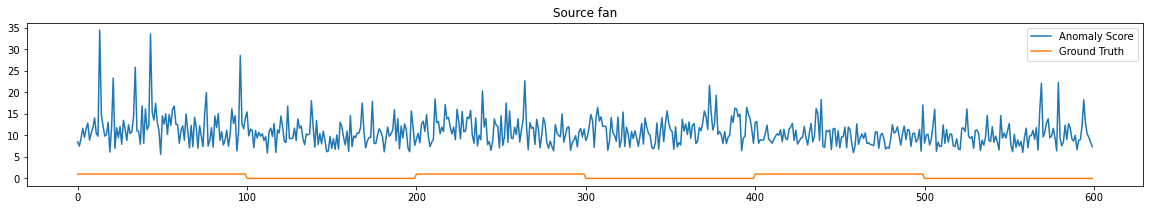

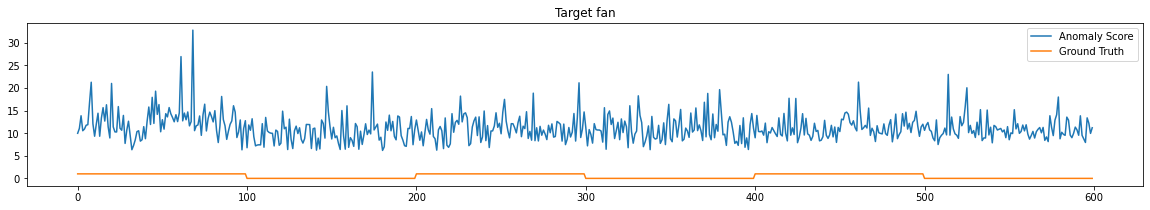

2021-04-26 21:46:24,343 - 01_eval.py - INFO - gearbox valid_source AUC : 0.726162996235989
2021-04-26 21:46:24,345 - 01_eval.py - INFO - gearbox valid_target AUC : 0.8067980428417322


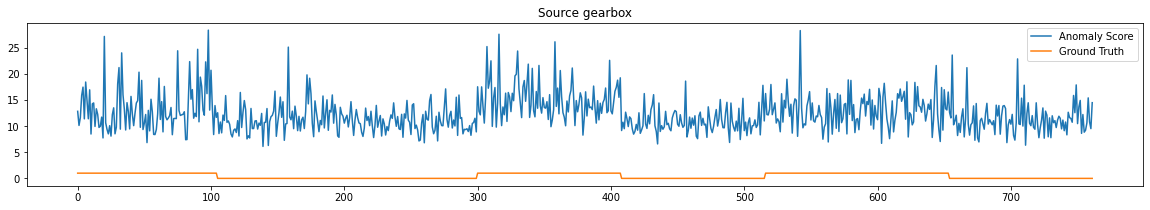

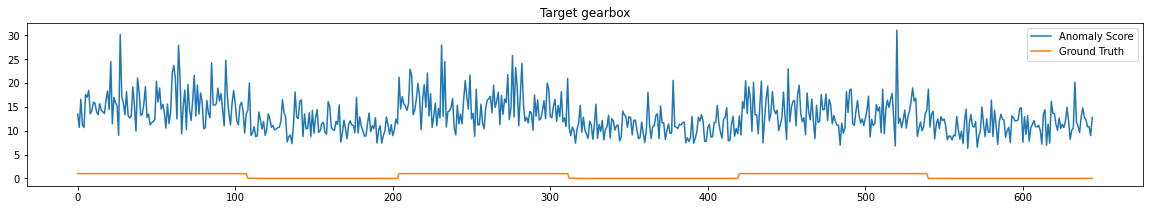

2021-04-26 21:46:27,711 - 01_eval.py - INFO - pump valid_source AUC : 0.5764888888888888
2021-04-26 21:46:27,714 - 01_eval.py - INFO - pump valid_target AUC : 0.48976666666666663


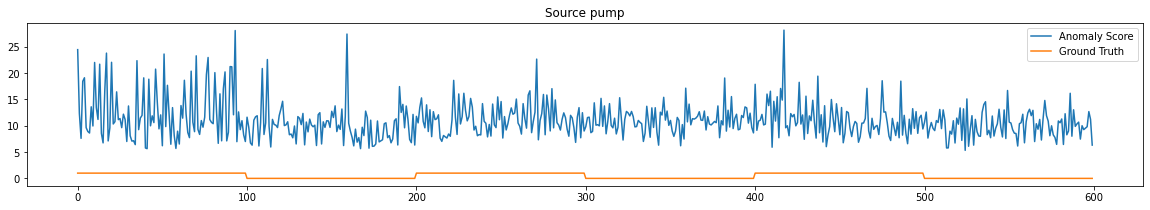

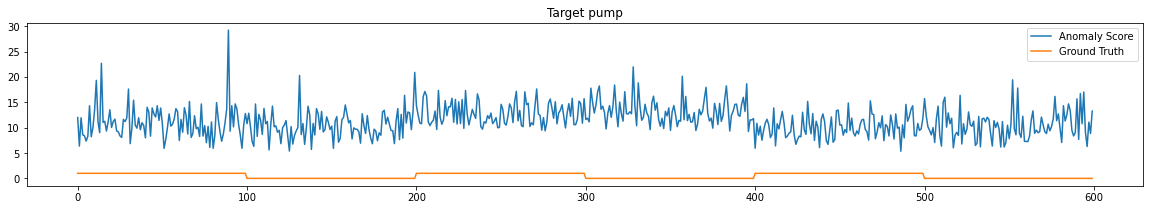

2021-04-26 21:46:30,969 - 01_eval.py - INFO - slider valid_source AUC : 0.6722602008117923
2021-04-26 21:46:30,972 - 01_eval.py - INFO - slider valid_target AUC : 0.5741169977924945


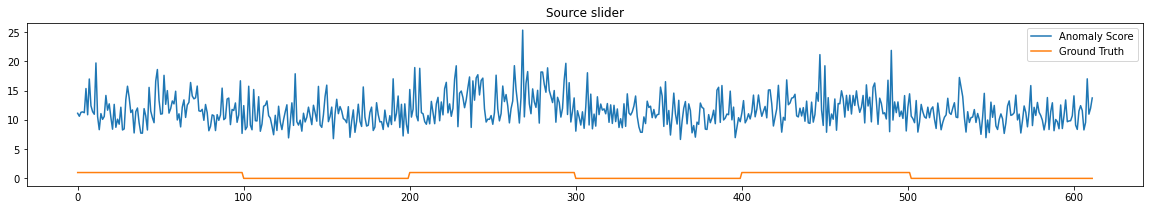

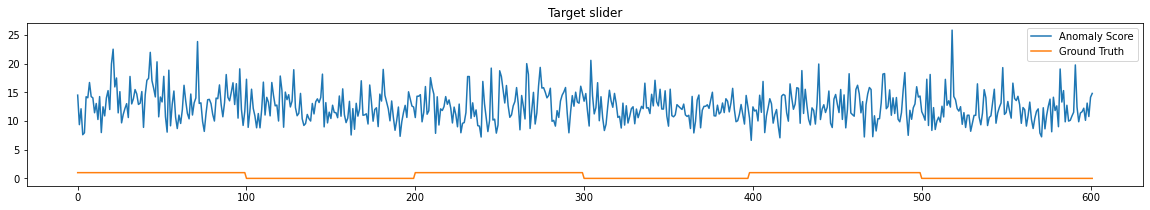

2021-04-26 21:46:34,757 - 01_eval.py - INFO - ToyCar valid_source AUC : 0.6211333333333333
2021-04-26 21:46:34,760 - 01_eval.py - INFO - ToyCar valid_target AUC : 0.5501888888888888


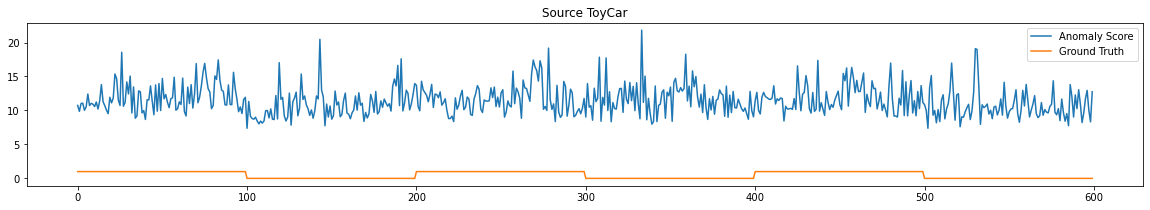

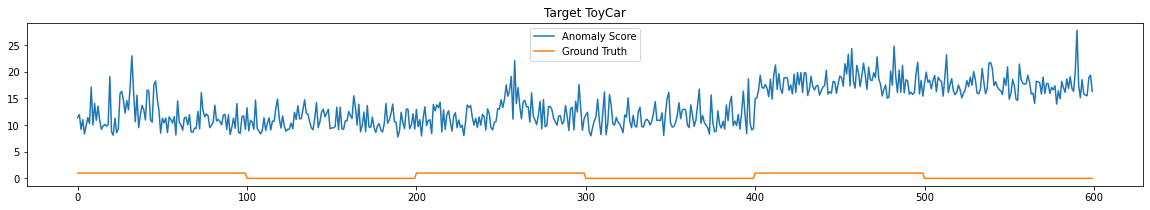

2021-04-26 21:46:38,393 - 01_eval.py - INFO - ToyTrain valid_source AUC : 0.48863333333333336
2021-04-26 21:46:38,395 - 01_eval.py - INFO - ToyTrain valid_target AUC : 0.5924555555555555


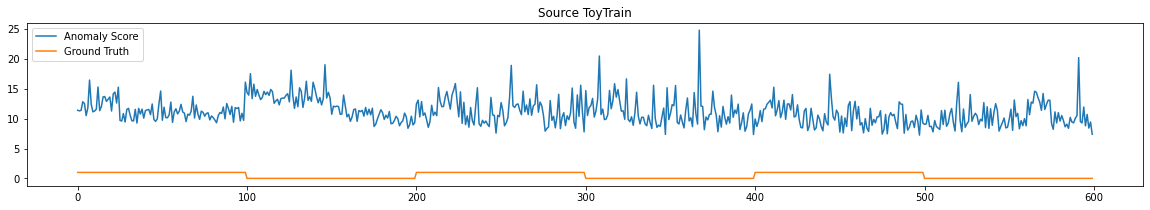

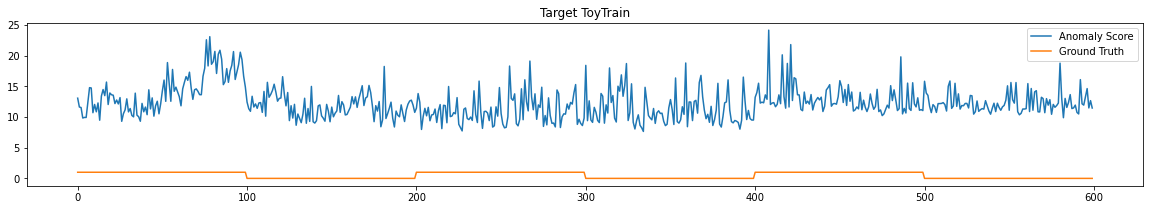

2021-04-26 21:46:41,914 - 01_eval.py - INFO - valve valid_source AUC : 0.5384666666666666
2021-04-26 21:46:41,916 - 01_eval.py - INFO - valve valid_target AUC : 0.5596777777777777


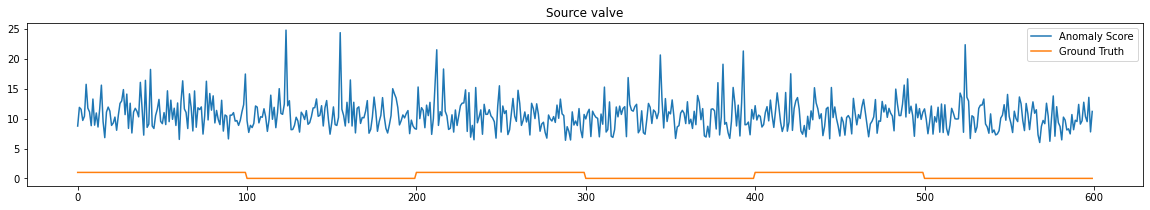

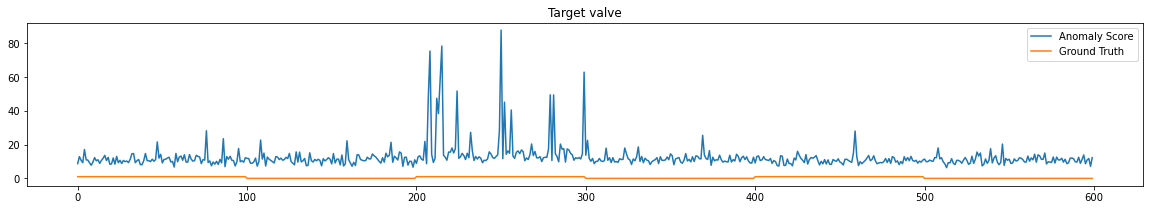

In [16]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = np.linalg.inv(MVG[machine_type]['cov'])
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')
    
    plt.figure(figsize=(20,3))
    plt.title(f'Source {machine_type}')
    plt.plot(valid_source_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_source']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(20,3))
    plt.title(f'Target {machine_type}')
    plt.plot(valid_target_dists, label='Anomaly Score')
    plt.plot(ext_data['valid_target']['labels'], label='Ground Truth')
    plt.legend()
    plt.show()

## calc GMM

In [17]:
machine_types

['fan', 'gearbox', 'pump', 'slider', 'ToyCar', 'ToyTrain', 'valve']

In [18]:
ext_data = load_ext_data(machine_types[6])
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(ext_data['train']['features'])

KeyboardInterrupt: 

In [ ]:
gmm.bic(ext_data['train']['features'])

In [ ]:
pred = gmm.predict(ext_data['train']['features'])

In [ ]:
plt.hist(pred)

In [ ]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_

In [ ]:
gmm_covs = gmm.covariances_
gmm_means = gmm.means_


# calc mahalanobis (Anomaly Score)
valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]

In [ ]:
for machine_type in machine_types:
    # get MVG
    mean = MVG[machine_type]['mean']
    cov_inv = MVG[machine_type]['cov']
    # load data
    ext_data = load_ext_data(machine_type)
    # calc mahalanobis (Anomaly Score)
    valid_source_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_source']['features']]
    valid_target_dists = [mahalanobis(sample, mean, cov_inv) for sample in ext_data['valid_target']['features']]
    # np.array
    valid_source_dists = np.array(valid_source_dists)
    valid_target_dists = np.array(valid_target_dists)
    # calc AUC
    roc_auc = roc_auc_score(ext_data['valid_source']['labels'], valid_source_dists)
    logger.info(f'{machine_type} valid_source AUC : {roc_auc}')
    roc_auc = roc_auc_score(ext_data['valid_target']['labels'], valid_target_dists)
    logger.info(f'{machine_type} valid_target AUC : {roc_auc}')

In [ ]:
gmm_section_types = gmm.predict(feats)

In [ ]:
sns.distplot(section_types)

In [ ]:
sns.displot(gmm_section_types)